<a href="https://colab.research.google.com/github/RomainCoulon/Python_lib/blob/main/measurementModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Measurement model

Import python modules

In [617]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics as sm_g

The measurement is based on a state space model including:
*   an expectation value *μ*
*   a gaussian white noise *ϵ* of variance *R*
*   a process noise (random gaussian walk) *δ* of variance *Q*
*   a determinstic drift *d* of slope *S*
*   a time step d*t*

The state space function gives a time series made of measurement values y and its decomposition with:
*   the true values of the process *x*
*   the deterministic component *d*

*t<sub>i<sub>* = *t<sub>i-1<sub>* + d*t*

*d<sub>i<sub>* = *d<sub>i-1<sub>* + *S*

*v<sub>i<sub>* = *v<sub>i-1<sub>* + *δ<sub>i<sub>*

*x<sub>i<sub>* = *x<sub>i-1<sub>* + *d<sub>i<sub>* + *v<sub>i<sub>*

*y<sub>i<sub>* = *x<sub>i<sub>* + *ϵ<sub>i<sub>*

with,

*d<sub>0<sub>* = *μ*

*v<sub>0<sub>* = 0

In [618]:
def stateSpace(N,mu,R,Q,S,dt):
    epsilon=np.random.normal(0,R,N)
    delta=np.random.normal(0,Q,N)
    t=np.arange(0,N,dt)
    x=[]  # random noise
    v=[]  # stochastic drift recurcive model
    y=[]  # measuremeent
    d=[]  # determinist drift recurvice model
    for i in range(N):
        if i==0:
            v.append(0)
            d.append(mu)
            x.append(v[-1]+d[-1])
            y.append(x[-1]+epsilon[i])
        else:
            v.append(v[-1]+delta[i])
            d.append(d[-1]+S)
            x.append(v[-1]+d[-1])
            y.append(x[-1]+epsilon[i])
    return y, x, d, t

Set the parameters of the model.

In [619]:
N=100
mu=10
R=1
Q=0.2
S=0
dt=1

A measurement *y* is generated.

In [620]:
y, x, d, t = stateSpace(N,mu,R,Q,S,dt)

A plot of the model is displayed. 

(array([ 6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.]),
 <a list of 10 Text major ticklabel objects>)

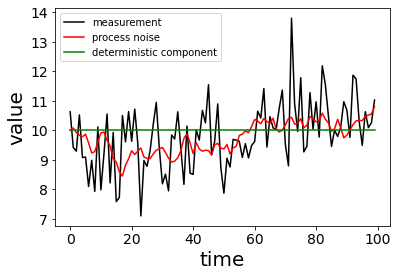

In [621]:
plt.figure("Plot measurement model")
plt.clf()
plt.plot(t,y,'-k',label=r"measurement")
plt.plot(t,x,'-r',label=r"process noise")
plt.plot(t,d,'-g',label=r"deterministic component")
plt.ylabel(r'value', fontsize=20)
plt.xlabel(r'time', fontsize=20)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Detection of autocorrelation

To test a data set, uncomment the code below and grab your data in 

```
y=[your data separated by comma]
```
otherwise the simulated data set will be used by default.
.

In [622]:
# y=[9.477601391341329, 9.679311929470055, 9.229645011585864, 11.95776479349741, 11.267684970683579, 9.968267233560518, 9.542540604675345, 8.93084879175725]
# N=len(y)
# t=np.arange(0,N,dt)

### Detection of autocorrelation using the Ljung-Box Q-Test.

In [623]:
def LjungBoxQtest(y,q):
  acf_result=sm.tsa.acf(y, nlags=N-1, qstat=True, fft=True)
  LB_pvalue=acf_result[2]
  if LB_pvalue[1]<1-q:
    testLBQ=True
  else:
    testLBQ=False
  return testLBQ


Set the confidence level *q*<sub>LBQ</sub> setting the risk of false detection *α = 1-q*<sub>LBQ</sub>.

In [624]:
q_LBQ=0.95

The hypothesis of non autocorrelation can be rejected with a confidence level 95%


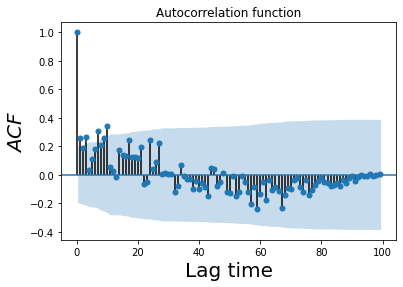

In [625]:
testLBQ = LjungBoxQtest(y,q_LBQ)
if testLBQ:
  print("The hypothesis of non autocorrelation can be rejected with a confidence level "+str(round(100*q_LBQ))+"%")
else:
  print("The hypothesis of non autocorrelation cannot be rejected with a confidence level "+str(round(100*q_LBQ))+"%")

fig = sm_g.tsaplots.plot_acf(y, lags=N-1, alpha =1-q_LBQ, fft=True)
plt.title("Autocorrelation function")
plt.xlabel(r"Lag time", fontsize=20)
plt.ylabel(r"$ACF$", fontsize=20)
plt.show()

### Detection of autocorrelation using CuSum chart

In [626]:
def cusumChartData(Val, *, delta=0.4, rate=1):
    n=len(Val)
    Rbar=np.mean(Val)
    Sig=np.std(Val)
    Cusum=np.empty(n)
    Cusum[0]=0
    for x in range(n):
        A=Val[x]-Rbar
        Cusum[x]=Cusum[x-1]+A
    d=(2/delta**2)*np.log((1-0.050)/(0.050))
    k=delta*Sig/2
    Vmask1=np.empty(n)
    Vmask2=np.empty(n)
    for x in range(n):
        Vmask1[x]=Cusum[n-1]-d*k-k*n+k*x
        Vmask2[x]=Cusum[n-1]+d*k+k*n-k*x
    CusumId=0
    for i in range(n):
        if Cusum[i]>Vmask2[i]:
            CusumId=CusumId+1
        if Cusum[i]<Vmask1[i]:
            CusumId=CusumId+1
    if CusumId>=rate: Test=True
    else: Test=False
    return Test, Cusum, Vmask1, Vmask2

Set the CuSum parameters *p*<sub>cusum</sub> and the number of points *n*<sub>cusum</sub> out of the Vmask to consider for detection. 

In [627]:
p_cusum=0.4
n_cusum=1

Run the CuSum chart analysis

Autocorrelation has been detected by the CuSum chart analysis


(array([-40., -30., -20., -10.,   0.,  10.,  20.,  30.,  40.]),
 <a list of 9 Text major ticklabel objects>)

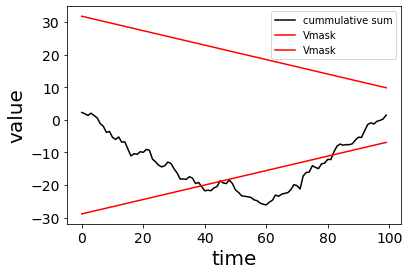

In [628]:
testCuSum, CuSum, Vmask1, Vmask2 = cusumChartData(y, delta=p_cusum, rate=n_cusum)
if testCuSum:
  print("Autocorrelation has been detected by the CuSum chart analysis")
else:
  print("Autocorrelation has not been detected by the CuSum chart analysis")

plt.figure("CuSum chart")
plt.clf()
plt.plot(t,CuSum,'-k',label=r"cummulative sum")
plt.plot(t,Vmask1,'-r',label=r"Vmask")
plt.plot(t,Vmask2,'-r',label=r"Vmask")
plt.ylabel(r'value', fontsize=20)
plt.xlabel(r'time', fontsize=20)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

### Detection of autocorrelation using EWMA chart

In [629]:
def ewmaChartData(Val, *, lambdaWMA=0.4, rate=1):
    lambdaWMA=2/len(Val)
    Rbar=np.mean(Val)
    Sig=np.std(Val)
    valEMA=[]
    LCL_EWMA=[]
    UCL_EWMA=[]
    for x, i in enumerate(Val):
        deltaWMA=3*np.sqrt((lambdaWMA/(2-lambdaWMA))*Sig**2*(1-(1-lambdaWMA)**(2*(x+1))))
        LCL_EWMA.append(Rbar-deltaWMA)
        UCL_EWMA.append(Rbar+deltaWMA)
        if x==0:
            valEMA.append(Rbar)
        else:
            valEMA.append(lambdaWMA*i+(1-lambdaWMA)*valEMA[-1])
    n=len(valEMA)
    EwmaId=0
    for i in range(n):
        if valEMA[i]>UCL_EWMA[i]:
            EwmaId=EwmaId+1
        if valEMA[i]<LCL_EWMA[i]:
            EwmaId=EwmaId+1
    if EwmaId>=rate: Test=True
    else: Test=False              
    return Test, valEMA, LCL_EWMA, UCL_EWMA

Set the EWMA parameters *p*<sub>ewma</sub> and the number of points *n*<sub>ewma</sub> out of the control limits to consider for detection.

In [630]:
p_ewma = 0.4
n_ewma = 1

Run the EWMA chart analysis.

Autocorrelation has been detected by the EWMA chart analysis


(array([ 9.4,  9.5,  9.6,  9.7,  9.8,  9.9, 10. , 10.1, 10.2]),
 <a list of 9 Text major ticklabel objects>)

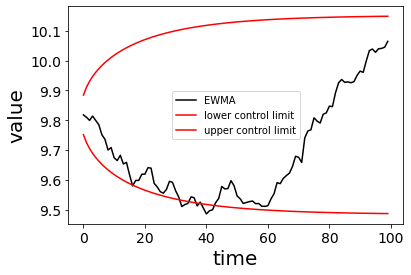

In [631]:
testEWMA, valEMA, LCL_EWMA, UCL_EWMA = ewmaChartData(y, lambdaWMA=p_ewma, rate=n_ewma)
if testEWMA:
  print("Autocorrelation has been detected by the EWMA chart analysis")
else:
  print("Autocorrelation has not been detected by the EWMA chart analysis")

plt.figure("EWMA chart")
plt.clf()
plt.plot(t,valEMA,'-k',label=r"EWMA")
plt.plot(t,LCL_EWMA,'-r',label=r"lower control limit")
plt.plot(t,UCL_EWMA,'-r',label=r"upper control limit")
plt.ylabel(r'value', fontsize=20)
plt.xlabel(r'time', fontsize=20)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

### Results

In [632]:
count=0
print("Presence of autocorrelation detected by ")
if testLBQ: print("Ljung-Box Q-Test "); count+=1
if testCuSum: print("CuSum chart "); count+=1
if testEWMA: print("EWMA chart "); count+=1
print("\t*"+str(count)+"/3 tests.")

Presence of autocorrelation detected by 
Ljung-Box Q-Test 
CuSum chart 
EWMA chart 
	*3/3 tests.
